In [1]:
import numpy as np
np.random.seed(19906)
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing import image
import cv2
import os
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.layers.core import Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
def get_im_cv2(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

使用InceptionV3模型

In [3]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

选择作为验证集的司机ID

In [4]:
drivers_pd = pd.read_csv("data/drivers_img_nop081_list.csv")
imgs_pd = drivers_pd["img"]
class_pd = drivers_pd["classname"]
subject_pd = drivers_pd["subject"]
choices = np.random.choice(drivers_pd["subject"].drop_duplicates(), 2)
print("选择作为验证集的司机ID:", choices)

选择作为验证集的司机ID: ['p041' 'p056']


按选择的司机ID分割训练集和验证集

In [5]:
val_index = []
for choice in choices:
    val_index.extend(subject_pd[subject_pd == choice].index.tolist())
    
test_mask = np.zeros(np.alen(subject_pd), dtype=np.bool)
for val_i in val_index:
    test_mask[val_i] = True
    
train_index = subject_pd[np.logical_not(test_mask)].index
print("分割的训练集数量:", np.alen(train_index), "，验证集数量:", np.alen(val_index))

分割的训练集数量: 20925 ，验证集数量: 1399


读取被数据增强处理的图片

In [6]:
drivers_aug_pd = pd.read_csv("data/drivers_img_aug_list.csv")
imgs_aug_pd = drivers_aug_pd["img"]
class_aug_pd = drivers_aug_pd["classname"]
subject_aug_pd = drivers_aug_pd["subject"]

In [7]:
exclude_index = []
for choice in choices:
    exclude_index.extend(subject_aug_pd[subject_aug_pd == choice].index.tolist())
test_aug_mask = np.zeros(np.alen(subject_aug_pd), dtype=np.bool)
for val_i in exclude_index:
    test_aug_mask[val_i] = True
    
train_aug_index = subject_aug_pd[np.logical_not(test_aug_mask)].index
print("从增强数据集中分割的训练集数量:", np.alen(train_aug_index))

从增强数据集中分割的训练集数量: 20925


创建图像数据处理目录

In [8]:
import os
import shutil

def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)
    
train_dir = "data/imgs/train2"
val_dir = "data/imgs/val2"
origin_test_dir = "data/imgs/test"
test_dir = "data/imgs/test1"
saved_weights = "saved_weights"
if not os.path.exists(saved_weights):
    os.mkdir(saved_weights)
    
# 因为加载测试集时目录中也需要有子目录，将data/imgs/test目录软链接到data/imgs/test1/test
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
    os.symlink('../test', test_dir+"/test")

# 在新的训练或验证集目录中为图片创建到原位置的链接
def link_imgs(target_dir, X, y):
    for img_name, target in zip(X, y):
        symlink_dir = os.path.join(target_dir, target)
        if not os.path.exists(symlink_dir):
            os.mkdir(symlink_dir)
        os.symlink('../../train/'+target+'/'+img_name, symlink_dir+'/'+img_name)
        
def link_aug_imgs(target_dir, X, y):
    for img_name, target in zip(X, y):
        symlink_dir = os.path.join(target_dir, target)
        if not os.path.exists(symlink_dir):
            os.mkdir(symlink_dir)
        os.symlink('../../train_aug/'+target+'/'+img_name, symlink_dir+'/'+img_name)

图片预处理

In [9]:
# 训练集图像生成器
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    rescale=1./255
)

# 验证集图像生成器
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255)

数据准备

In [10]:
# 图像生成器输出的图像大小
out_image_size = (299, 299)
batch_size = 96

In [11]:
# 删除上次K折循环分离出的训练集和验证集文件，并重新创建目录
rmrf_mkdir(train_dir)
rmrf_mkdir(val_dir)

X_train, X_val = imgs_pd[train_index], imgs_pd[val_index]
y_train, y_val = class_pd[train_index], class_pd[val_index]

# 链接训练集到新的目录中
link_imgs(train_dir, X_train, y_train)

# 链接增强训练集到新的目录中
X_aug_train, y_aug_train = imgs_aug_pd[train_aug_index], class_aug_pd[train_aug_index]
link_aug_imgs(train_dir, X_aug_train, y_aug_train)

# 链接验证集到新的目录中
link_imgs(val_dir, X_val, y_val)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=out_image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=out_image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

Found 41850 images belonging to 10 classes.
Found 1399 images belonging to 10 classes.


构建模型

In [24]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax', use_bias=False, kernel_regularizer=l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions, name=base_model.name)

# op = SGD(lr=0.0002, decay=20e-8, momentum=0.9, nesterov=True)
op = Adam(lr=0.0001)
model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])

开始训练

In [25]:
# 训练代数
epochs = 4

callbacks = [EarlyStopping(monitor="val_loss", verbose=1, mode="min", 
                              min_delta=0.0005, patience=2)]

history = model.fit_generator(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_generator)

Epoch 1/50
436/436 [==============================] - 1066s 2s/step - loss: 0.3997 - acc: 0.9319 - val_loss: 0.3037 - val_acc: 0.9550
Epoch 2/50
436/436 [==============================] - 1069s 2s/step - loss: 0.1476 - acc: 0.9952 - val_loss: 0.1503 - val_acc: 0.9807
Epoch 3/50
436/436 [==============================] - 1092s 3s/step - loss: 0.0880 - acc: 0.9978 - val_loss: 0.1798 - val_acc: 0.9492
Epoch 4/50
436/436 [==============================] - 1095s 3s/step - loss: 0.0520 - acc: 0.9986 - val_loss: 0.0786 - val_acc: 0.9900
Epoch 5/50
436/436 [==============================] - 1075s 2s/step - loss: 0.0372 - acc: 0.9979 - val_loss: 0.3005 - val_acc: 0.9114
Epoch 6/50
436/436 [==============================] - 1077s 2s/step - loss: 0.0307 - acc: 0.9977 - val_loss: 0.2484 - val_acc: 0.9328
Epoch 7/50
436/436 [==============================] - 1059s 2s/step - loss: 0.0241 - acc: 0.9983 - val_loss: 0.1068 - val_acc: 0.9700
Epoch 8/50
  6/436 [..............................] - ETA: 8:4

KeyboardInterrupt: 

训练结果处理

In [16]:
# 保存模型
save_file = saved_weights + '/' + model.name + '_model.h5'
print("model name:", model.name, ", will save weight file:", save_file)
model.save(save_file)

model name: inception_v3 , will save weight file: saved_weights/inception_v3_model.h5


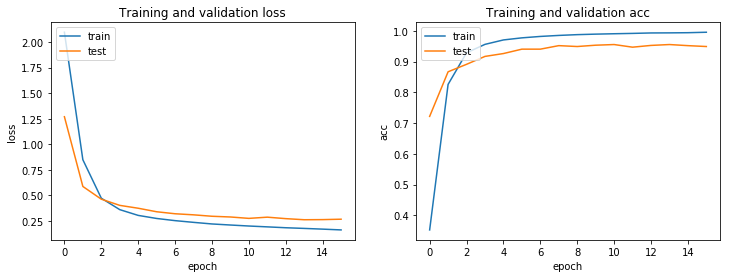

In [18]:
# 绘制图型
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and validation acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

使用低学习率SGD，再训练，让模型收敛

In [19]:
fine_tuning_layer = 172

# for layer in model.layers[:fine_tuning_layer]:
#     layer.trainable = False
# for layer in model.layers[fine_tuning_layer:]:
#     layer.trainable = True
    
op = SGD(lr=0.00001, decay=1e-8, momentum=0.9, nesterov=True)
model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# 训练代数
epochs = 10

callbacks = [EarlyStopping(monitor="val_loss", verbose=1, mode="min", 
                              min_delta=0.0003, patience=3)]

history = model.fit_generator(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_generator)

Epoch 1/10
436/436 [==============================] - 1086s 2s/step - loss: 0.1577 - acc: 0.9955 - val_loss: 0.2649 - val_acc: 0.9492
Epoch 2/10
436/436 [==============================] - 1089s 2s/step - loss: 0.1581 - acc: 0.9954 - val_loss: 0.2627 - val_acc: 0.9514
Epoch 3/10
436/436 [==============================] - 1057s 2s/step - loss: 0.1574 - acc: 0.9955 - val_loss: 0.2656 - val_acc: 0.9492
Epoch 4/10
  6/436 [..............................] - ETA: 8:24 - loss: 0.1643 - acc: 0.9913

KeyboardInterrupt: 

再次保存最终训练结果权重

In [22]:
# 保存权重
save_file = saved_weights + '/' + model.name + '_last_model.h5'
print("model name:", model.name, ", will save weight file:", save_file)
model.save(save_file)

model name: inception_v3 , will save weight file: saved_weights/inception_v3_last.h5


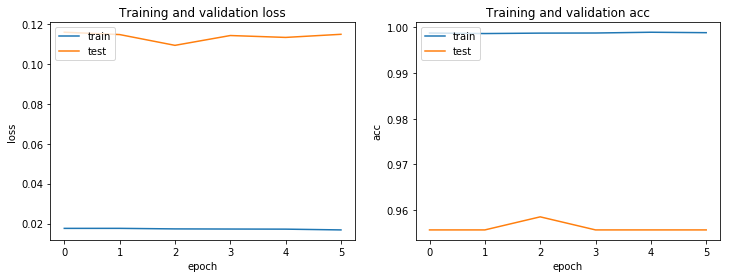

In [23]:
# 绘制图型
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and validation acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

测试预测结果

In [21]:
from keras.models import load_model

pred_model = load_model("saved_weights/inception_v3_model.h5")

预测所有测试集，并生成提交kaggle的报告

In [22]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
pred_batch_size=128

test_generator = test_datagen.flow_from_directory(test_dir, out_image_size, shuffle=False, 
                                             batch_size=pred_batch_size, class_mode=None)

test_generator.filenames[0]

Found 79726 images belonging to 1 classes.


'test/img_1.jpg'

In [23]:
# model.load_weights("saved_weights/inception_v3.h5")
# op = SGD(lr=0.00001, decay=30e-8, momentum=0.9, nesterov=True)
# model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])

sub_df = pd.read_csv("data/sample_submission.csv")

y_preds = pred_model.predict_generator(test_generator, verbose=1)
y_preds = y_preds.clip(min=0.005, max=0.995)
print("y_pred shape {}".format(y_preds.shape))

for i, fname in enumerate(test_generator.filenames):
    y_pred = y_preds[i]
    for k, c in enumerate(y_pred):
        sub_df.at[i, 'c'+str(k)] = c

print(sub_df.head())

sub_df.to_csv('data/pred.csv', index=None)
print("predict done.")

623/623 [==============================] - 1382s 2s/step
y_pred shape (79726, 10)
              img        c0     c1        c2        c3       c4        c5  \
0       img_1.jpg  0.009252  0.005  0.005000  0.006030  0.00572  0.956020   
1      img_10.jpg  0.005000  0.005  0.005000  0.005000  0.00500  0.995000   
2     img_100.jpg  0.899340  0.005  0.005000  0.005000  0.00500  0.012258   
3    img_1000.jpg  0.005000  0.005  0.045862  0.005000  0.00500  0.005000   
4  img_100000.jpg  0.005000  0.005  0.005000  0.993317  0.00500  0.005000   

      c6     c7        c8        c9  
0  0.005  0.005  0.005000  0.009409  
1  0.005  0.005  0.005000  0.005000  
2  0.005  0.005  0.005000  0.073961  
3  0.005  0.005  0.938109  0.005000  
4  0.005  0.005  0.005000  0.005000  
predict done.


提交到kaggle中后得到成绩：private:  0.32960, public: 0.32179